In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
import xmltodict
import json

from IPython.display import Image

## 1. Obtener el listado de proyectos

Para acceder al listado de reformas constitucionales primero debemos visitar la [página del Senado](https://www.senado.cl) e ir a "Trámite de Proyectos" en el lado derecho de la barra superior como lo indica la imagen.

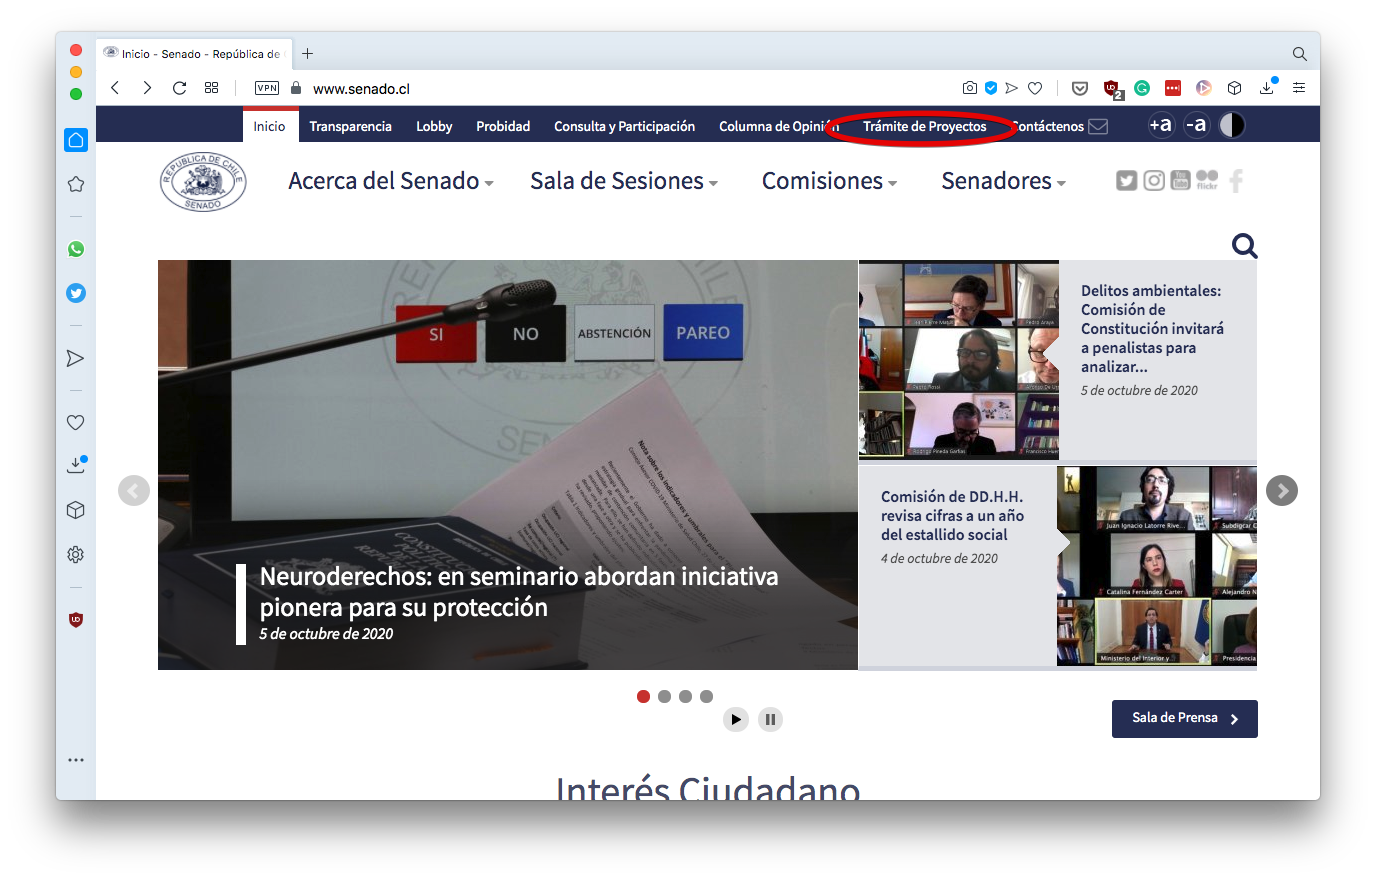

In [2]:
Image("tramite.png", width=800)

Una vez ahí, seleccionamos "Consulta Avanzada".

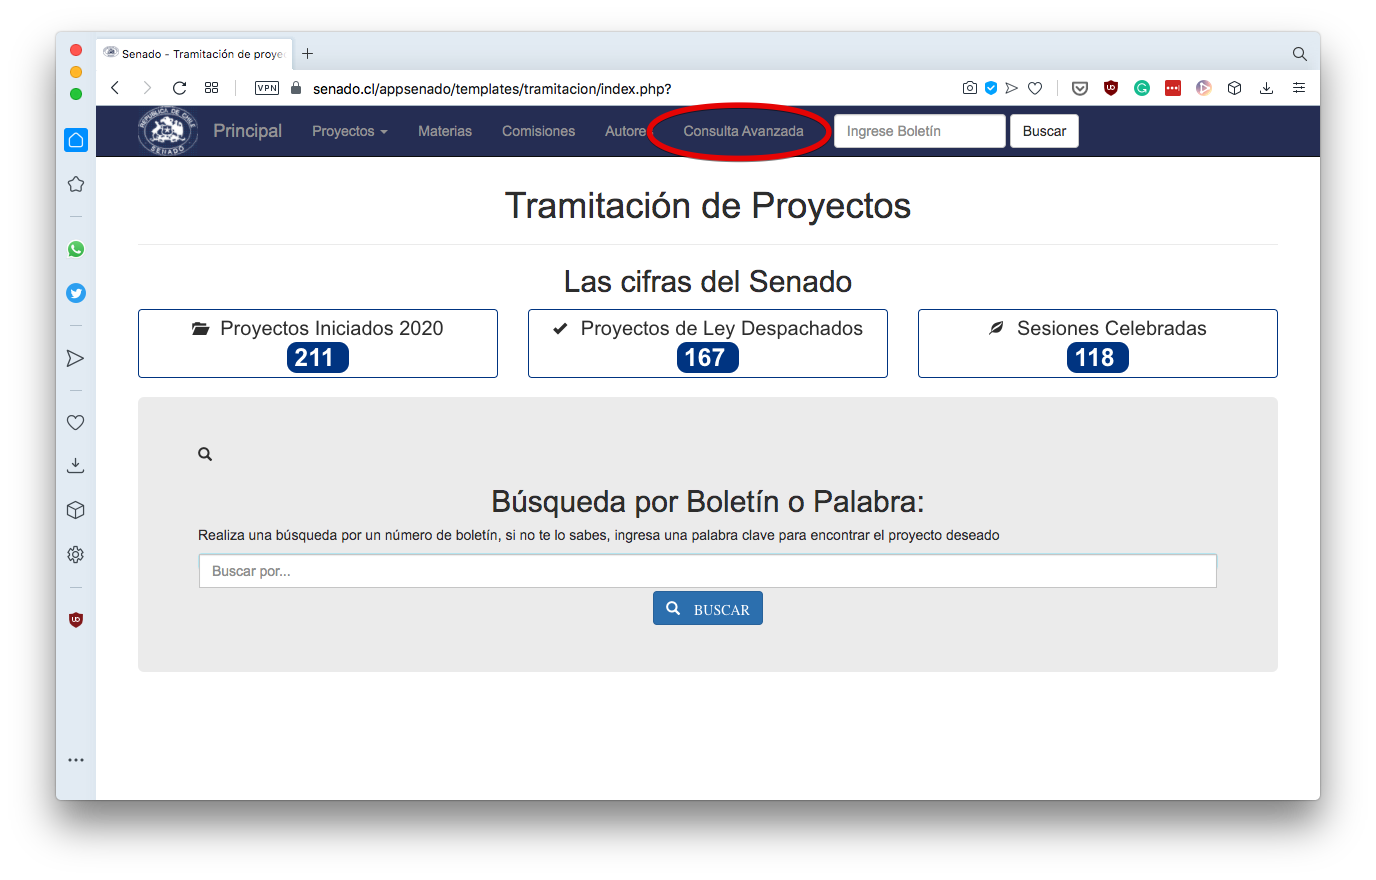

In [3]:
Image("consulta_avanzada.png", width=800)

En los selectores de la izquierda, en "Tipo Proyecto" elegimos "Reforma Constitucional" y apretamos el botón "Consultar".

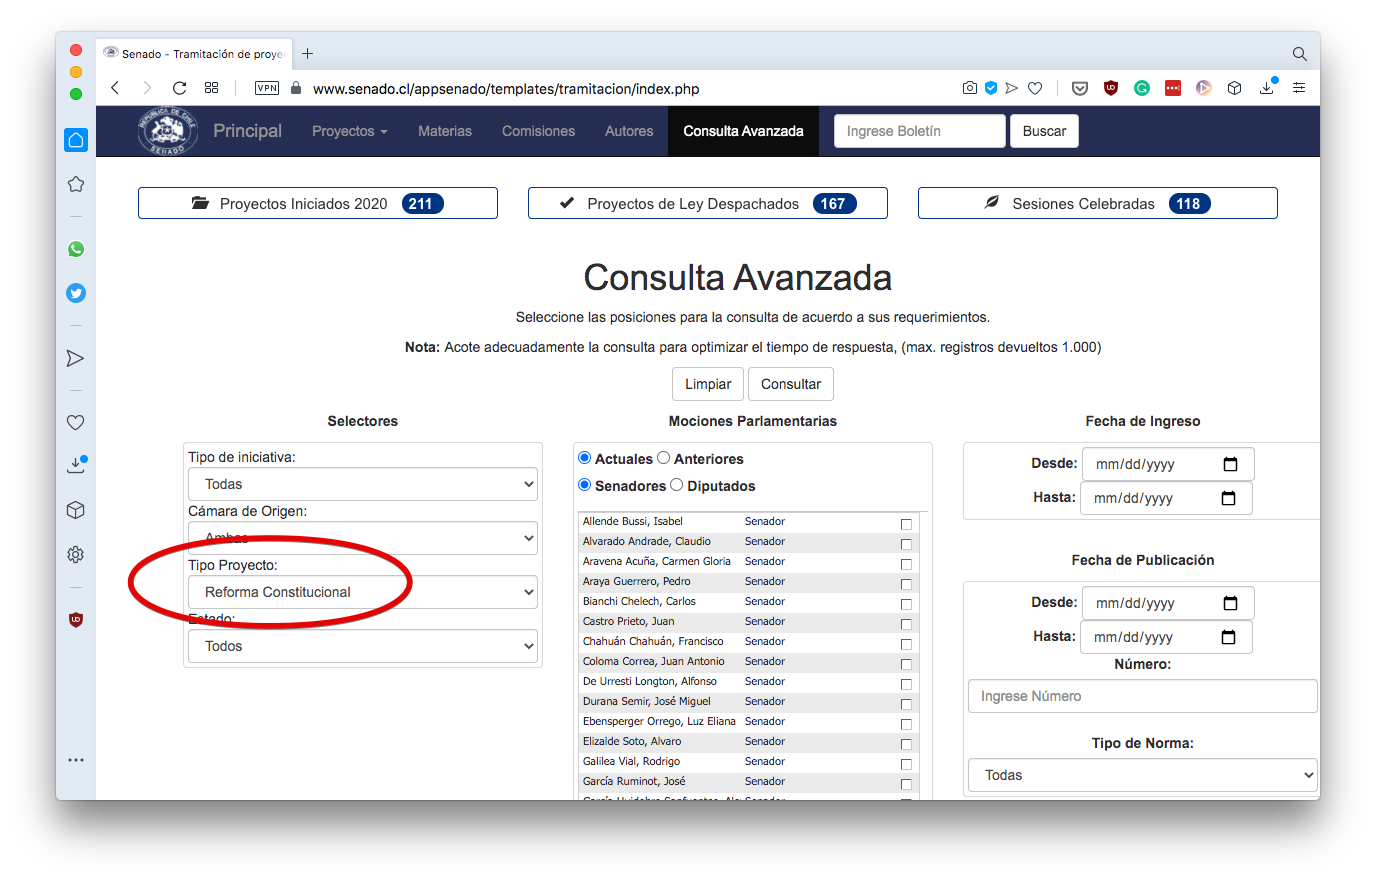

In [4]:
Image("reformas.png", width=800)

Cuando nos arroje los resultados, apretamos en el botón "Excel" el cual descargará un archivo llamado "grid.xlsx" que es el cual usaremos para el procesamiento de datos.

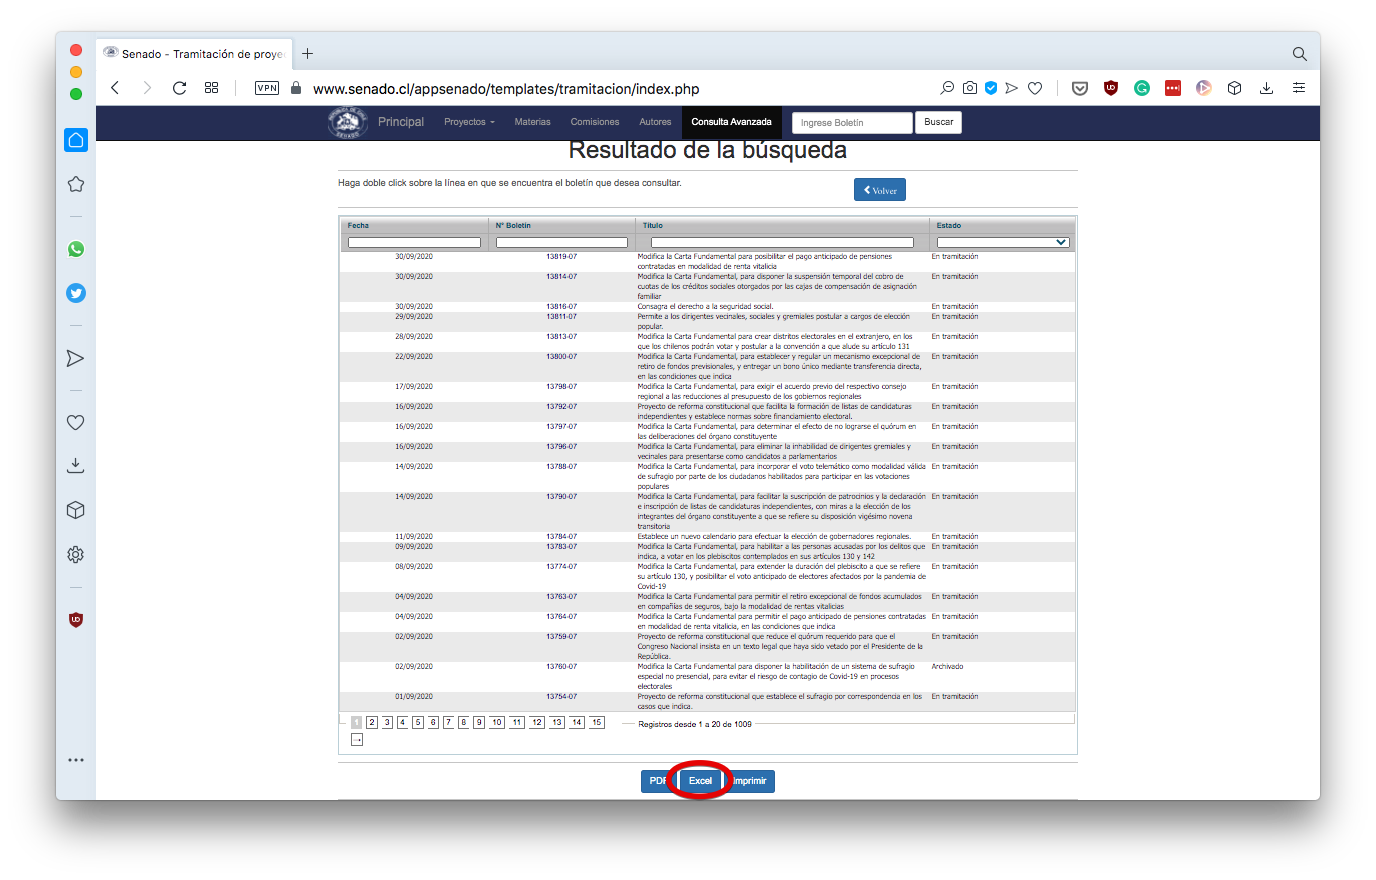

In [5]:
Image("grid.png", width=800)

## 2. Procesar los datos

Primero cargamos el archivo grid.xlsx para ver su contenido.

In [6]:
df = pd.read_excel('../data/grid.xlsx')
df.head()

,Fecha,N° Boletín,Título,Estado
0,30/09/2020,13819-07,Modifica la Carta Fundamental para posibilitar...,En tramitación
1,30/09/2020,13814-07,"Modifica la Carta Fundamental, para disponer l...",En tramitación
2,30/09/2020,13816-07,Consagra el derecho a la seguridad social.,En tramitación
3,29/09/2020,13811-07,"Permite a los dirigentes vecinales, sociales y...",En tramitación
4,28/09/2020,13813-07,Modifica la Carta Fundamental para crear distr...,En tramitación


In [ ]:
pd.unique(df['Estado'].values.ravel())

Ahora la idea es obtener más información respecto a cada uno de los proyectos. Para eso usamos la [API del senado](http://opendata.congreso.cl), la cual recibe el número de boletín que se especifica en el archivo grid.xlsx como argumento. Adicionalmente, modificamos el orden de la información arrojada por la API para adecuarlo al formato que usaremos para la visualización.

In [7]:
def get_url(string):
    return "https://www.senado.cl/wspublico/tramitacion.php?boletin=" + string

campos = [['autores', 'autor'], ['comparados', 'comparado'], ['materias', 'materia'],
        ['indicaciones', 'indicacion'], ['informes', 'informe'],
        ['oficios', 'oficio'], ['tramitacion', 'tramite'],
        ['urgencias', 'urgencia'], ['votaciones', 'votacion']]

new_json = []

for i in range(df.shape[0]-1, -1, -1):

    boletin = df.iloc[i]['N° Boletín'].split('-')[0]
    url = get_url(boletin)

    file = urlopen(url)
    xmldata = file.read()
    file.close()

    data = xmltodict.parse(xmldata, force_list=('indicacion', 'informe', 'oficio', 'tramite',
                                               'urgencia', 'votacion'))
    json_data = json.dumps(data, ensure_ascii=False)
    projects = json.loads(json_data)

    proyecto = projects['proyectos']['proyecto']
    json_project = {}
    json_project['descripcion'] = proyecto['descripcion']
    for campo in campos:
        if proyecto[campo[0]] is not None:
            json_project[campo[0]] = proyecto[campo[0]][campo[1]]
            if campo[0] == 'tramitacion':
                arr = []
                for i,tramite in enumerate(json_project[campo[0]]):
                    if i == 0:
                        obj = {}
                        camara = tramite['CAMARATRAMITE']
                        fecha_inicio = tramite['FECHA']
                    if tramite['CAMARATRAMITE'] != camara:
                        fecha_termino = tramite['FECHA']
                        obj['camara'] = camara
                        obj['inicio'] = fecha_inicio
                        obj['termino'] = fecha_termino
                        arr.append(obj)

                        obj = {}
                        camara = tramite['CAMARATRAMITE']
                        fecha_inicio = tramite['FECHA']
                    if i == len(json_project[campo[0]]) - 1:
                        fecha_termino = tramite['FECHA']
                        obj['camara'] = camara
                        obj['inicio'] = fecha_inicio
                        obj['termino'] = fecha_termino
                        arr.append(obj)
                json_project['camaras'] = arr
        else:
            json_project[campo[0]] = None
            if campo[0] == 'tramitacion':
                json_project['camaras'] = None
            
    new_json.append(json_project)

Ahora arreglamos algunos nombres que están escritos de diferente forma para estandarizarlos

In [9]:
def fix_name(autor):
    obj = {}
    name = list(autor.values())[0]
    if name == 'Muñoz D`Albora, Adriana':
        key = list(autor.keys())[0]
        obj[key] = "Muñoz D'Albora, Adriana"
    elif name == 'García-Huidobro Sanfuentes, Alejandro':
        key = list(autor.keys())[0]
        obj[key] = 'García Huidobro Sanfuentes, Alejandro'
    elif name == 'Naranjo Ortíz, Jaime':
        key = list(autor.keys())[0]
        obj[key] = 'Naranjo Ortiz, Jaime'
    elif name == 'Tuma Zedán, Eugenio':
        key = list(autor.keys())[0]
        obj[key] = 'Tuma Zedan, Eugenio'
    else:
        obj = autor
    return obj

authors = []
for proyecto in new_json:
    autores = proyecto['autores']
    if autores is None:
        continue
    elif isinstance(autores, list):
        for autor in autores:
            autor = fix_name(autor)
            authors.append(list(autor.values())[0])
    elif isinstance(autores, object):
        autores = fix_name(autores)
        authors.append(list(autores.values())[0])

Finalmente guardamos nuestro nuevo archivo en formato json para usarlo en la visualización.

In [ ]:
with open("../data/reformas.json", "w") as json_file:
    this_file = json.dumps(new_json, ensure_ascii=False)
    json_file.write(this_file)

## 3. Bonus: encontrar parlamentarios con más proyectos ingresados

In [10]:
from collections import Counter

names = np.array(list(Counter(authors).keys()))
times = np.array(list(Counter(authors).values()))

indices = np.argsort(times)
names[indices]

array(['Bosselin Correa, Carlos', 'Bombal Otaegui, Carlos',
       'Hernández Saffirio, Miguel', 'Fossa Rojas, Haroldo',
       'Prochelle Aguilar, Marina', 'González Román, Rosa',
       'Mesías Lehu, Iván', 'Villegas González, Erick',
       'Paya Mira, Darío', 'Leay Morán, Cristián',
       'Correa De la Cerda, Sergio', 'Carrera Villavicencio, Ma Elena',
       'Urrutia Avila, Raúl', 'González Rodríguez, José Luis',
       'Tohá González, Isidoro Francisco', 'Dupre Silva, Carlos',
       'Aylwin Oyarzún, Mariana', 'McIntyre Mendoza, Ronald',
       'Foxley Rioseco, Alejandro', 'Fantuzzi Hernandez, Angel',
       'Aburto Ochoa, Marcos', 'Prat Alemparte, Francisco',
       'Keitel Bianchi, Sebastián', 'Álvarez Ramírez, Sebastián',
       'De Mussy Hiriart, Felipe', 'Larrain Peña, Carlos',
       'Salaberry Soto, Felipe', 'Letelier Aguilar, Cristian',
       'Dittborn Cordúa, Julio', 'Forni Lobos, Marcelo',
       'Egaña Respaldiza, Andrés', 'Fuentes Barros, Tomás Andrés',
       'Aran

In [11]:
times[indices]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  7,  7,  7,  7